# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [21]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/appbites/Desktop/mlfs-book
HopsworksSettings initialized!


In [22]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [23]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 14, 20, 12, 50, 713175)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [24]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
# location = json.loads(location_str)
# country=location['country']
# city=location['city']
# street=location['street']

country="Austria"
city="Vienna"

2025-11-14 20:12:52,821 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 20:12:52,826 INFO: Initializing external client
2025-11-14 20:12:52,827 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-14 20:12:53,462 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-14 20:12:54,375 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1289364


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [25]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="stations_air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-14 20:13:02,584 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/576460 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19635 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120461 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119498 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/116497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/119661 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117145 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118807 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117302 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118124 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120079 elapsed<00:00 remaining<?

In [26]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.3289623E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [27]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-15 00:00:00+00:00,9.60,0.0,5.483356,113.198624,vienna
1,2025-11-16 00:00:00+00:00,13.15,0.0,2.595997,146.309906,vienna
2,2025-11-17 00:00:00+00:00,8.65,0.9,5.154416,347.905273,vienna
3,2025-11-18 00:00:00+00:00,6.60,0.0,4.198285,300.963684,vienna
4,2025-11-16 00:00:00+00:00,12.60,0.0,5.804825,150.255203,Vienna
5,2025-11-15 00:00:00+00:00,9.05,0.0,6.792466,122.005348,Vienna
6,2025-11-18 00:00:00+00:00,5.85,0.0,12.181625,288.970490,Vienna
7,2025-11-17 00:00:00+00:00,8.25,1.8,7.100310,329.534515,Vienna
8,2025-11-19 00:00:00+00:00,5.75,0.0,2.099143,149.036316,vienna
9,2025-11-19 00:00:00+00:00,5.20,0.0,13.044724,152.020615,Vienna


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [28]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-15 00:00:00+00:00,9.60,0.0,5.483356,113.198624,vienna,104.693512
1,2025-11-16 00:00:00+00:00,13.15,0.0,2.595997,146.309906,vienna,93.305168
2,2025-11-17 00:00:00+00:00,8.65,0.9,5.154416,347.905273,vienna,50.649998
3,2025-11-18 00:00:00+00:00,6.60,0.0,4.198285,300.963684,vienna,98.944481
4,2025-11-16 00:00:00+00:00,12.60,0.0,5.804825,150.255203,Vienna,88.329155
5,2025-11-15 00:00:00+00:00,9.05,0.0,6.792466,122.005348,Vienna,79.699448
6,2025-11-18 00:00:00+00:00,5.85,0.0,12.181625,288.970490,Vienna,107.893669
7,2025-11-17 00:00:00+00:00,8.25,1.8,7.100310,329.534515,Vienna,67.296631
8,2025-11-19 00:00:00+00:00,5.75,0.0,2.099143,149.036316,vienna,88.469315
9,2025-11-19 00:00:00+00:00,5.20,0.0,13.044724,152.020615,Vienna,71.367149


In [29]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         12 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          12 non-null     float32                
 2   precipitation_sum            12 non-null     float32                
 3   wind_speed_10m_max           12 non-null     float32                
 4   wind_direction_10m_dominant  12 non-null     float32                
 5   city                         12 non-null     object                 
 6   predicted_pm25               12 non-null     float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 560.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [31]:
# batch_data['street'] = street
# batch_data['city'] = city
# batch_data['country'] = country
# # Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
# batch_data = batch_data.sort_values(by=['date'])
# batch_data

# Load metadata for all stations
stations_path = Path(f"{root_dir}/stations.json")
with open(stations_path, "r") as f:
    stations_meta = json.load(f)

print(f"Loaded {len(stations_meta)} stations for forecasting")

all_predictions = []

# Loop through every station and create its predictions
for s in stations_meta:
    uid = s["uid"]
    city = s["city"]
    country = s["country"]
    street = s["street"]

    # Filter the weather FG for this city's data
    # (since the weather FG is city-level, all stations share same weather)
    station_weather = batch_data.copy()
    station_weather["station_uid"] = uid
    station_weather["street"] = street
    station_weather["city"] = city
    station_weather["country"] = country

    # Compute predictions
    features = station_weather[
        ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]
    ]
    station_weather["predicted_pm25"] = retrieved_xgboost_model.predict(features)

    # Add forecast horizon counter
    station_weather["days_before_forecast_day"] = range(1, len(station_weather) + 1)

    # Append to master list
    all_predictions.append(station_weather)

# Combine all stations' data into one DataFrame
predictions_df = pd.concat(all_predictions, ignore_index=True)
predictions_df = predictions_df.sort_values(by=["station_uid", "date"])

print(f" Created {len(predictions_df)} forecast records across all stations")
display(predictions_df.head())


Loaded 9 stations for forecasting
 Created 108 forecast records across all stations


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,station_uid,street,country,days_before_forecast_day
72,2025-11-15 00:00:00+00:00,9.60,0.0,5.483356,113.198624,Vienna,104.693512,2850,Kendlerstraße 40 (Umspannwerk),Austria,1
77,2025-11-15 00:00:00+00:00,9.05,0.0,6.792466,122.005348,Vienna,79.699448,2850,Kendlerstraße 40 (Umspannwerk),Austria,6
73,2025-11-16 00:00:00+00:00,13.15,0.0,2.595997,146.309906,Vienna,93.305168,2850,Kendlerstraße 40 (Umspannwerk),Austria,2
76,2025-11-16 00:00:00+00:00,12.60,0.0,5.804825,150.255203,Vienna,88.329155,2850,Kendlerstraße 40 (Umspannwerk),Austria,5
74,2025-11-17 00:00:00+00:00,8.65,0.9,5.154416,347.905273,Vienna,50.649998,2850,Kendlerstraße 40 (Umspannwerk),Austria,3


In [32]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         12 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          12 non-null     float32                
 2   precipitation_sum            12 non-null     float32                
 3   wind_speed_10m_max           12 non-null     float32                
 4   wind_direction_10m_dominant  12 non-null     float32                
 5   city                         12 non-null     object                 
 6   predicted_pm25               12 non-null     float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 560.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

📁 Base output directory: /Users/appbites/Desktop/mlfs-book/docs/air-quality/assets/img
Generating forecast plot for Floridsdorf, Gerichtsgasse 1a (Prager Str. 65m) (UID: 4738)


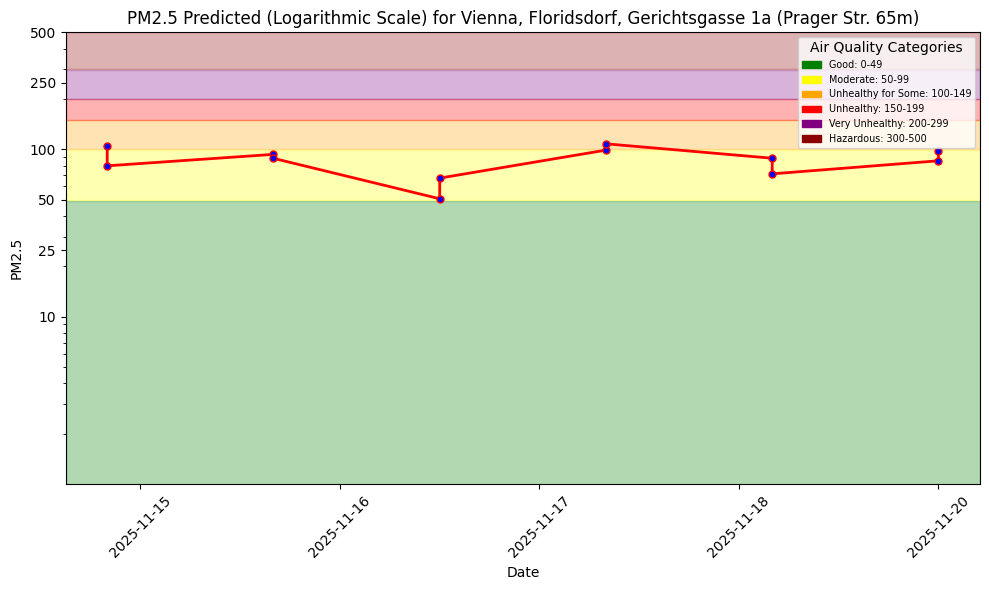

Generating forecast plot for Schafbergbad, Josef Redl Gasse 2, Gstr.Nr. 698 (UID: 4739)


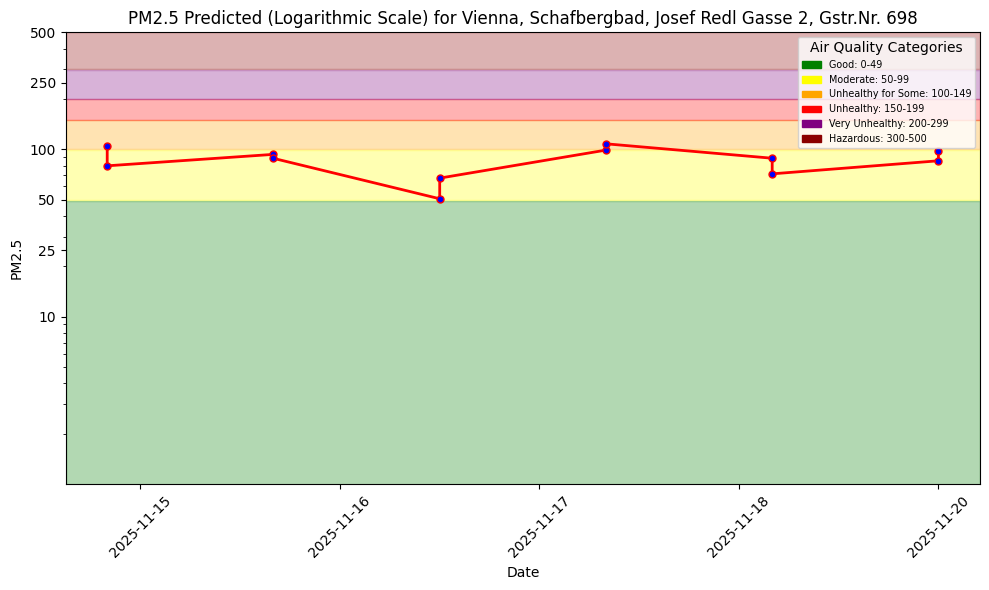

Generating forecast plot for Wehlistraße 366, Gstr.Nr.2157 (UID: 4736)


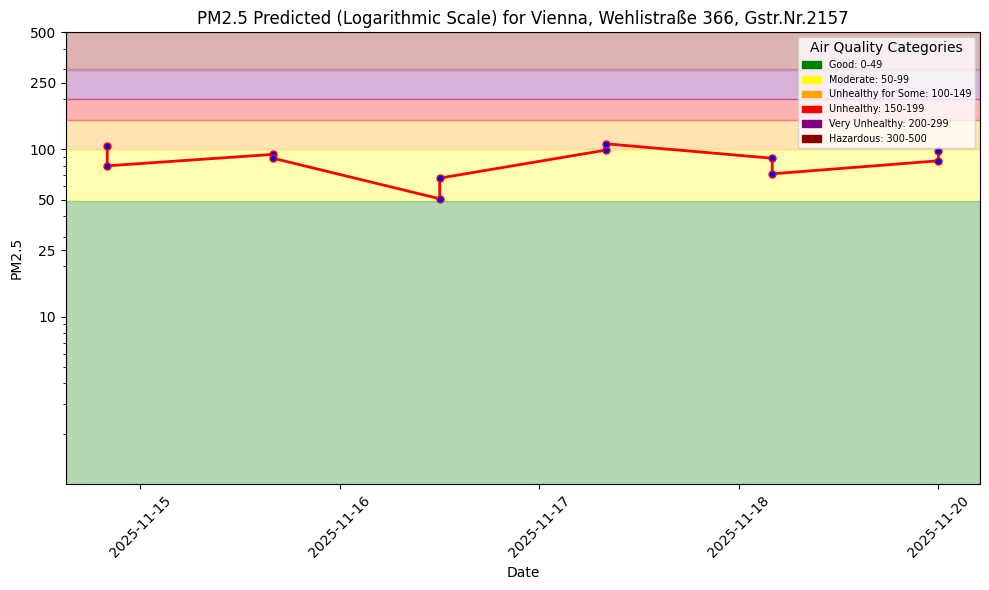

Generating forecast plot for Ostringweg (zwischen Gebäuden BT25) (UID: 14537)


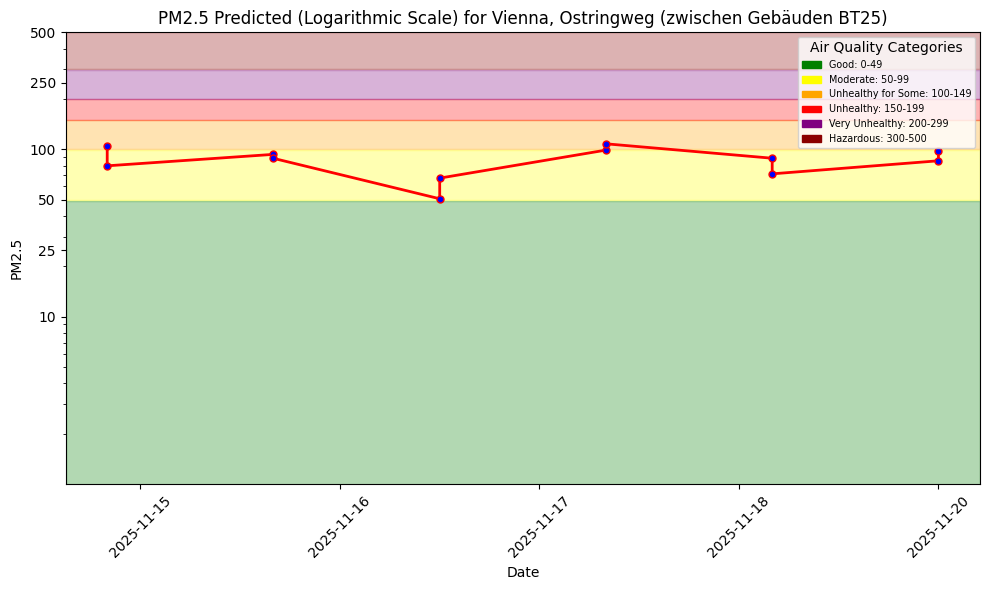

Generating forecast plot for Hausgrundweg 23, Gstr. 254 (UID: 2855)


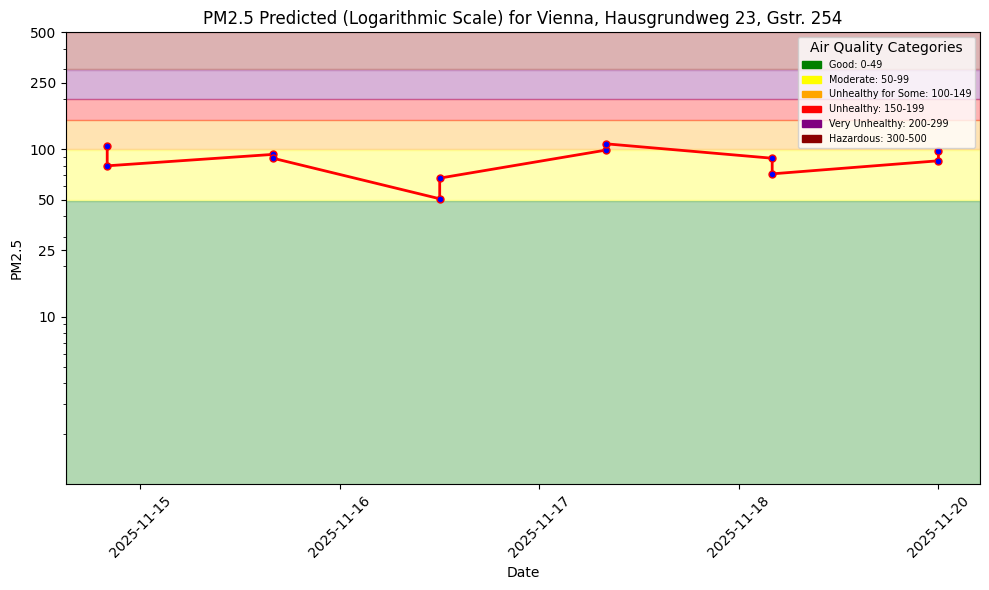

Generating forecast plot for Umspannwerk Gaudenzdorfer Gürtel (UID: 2857)


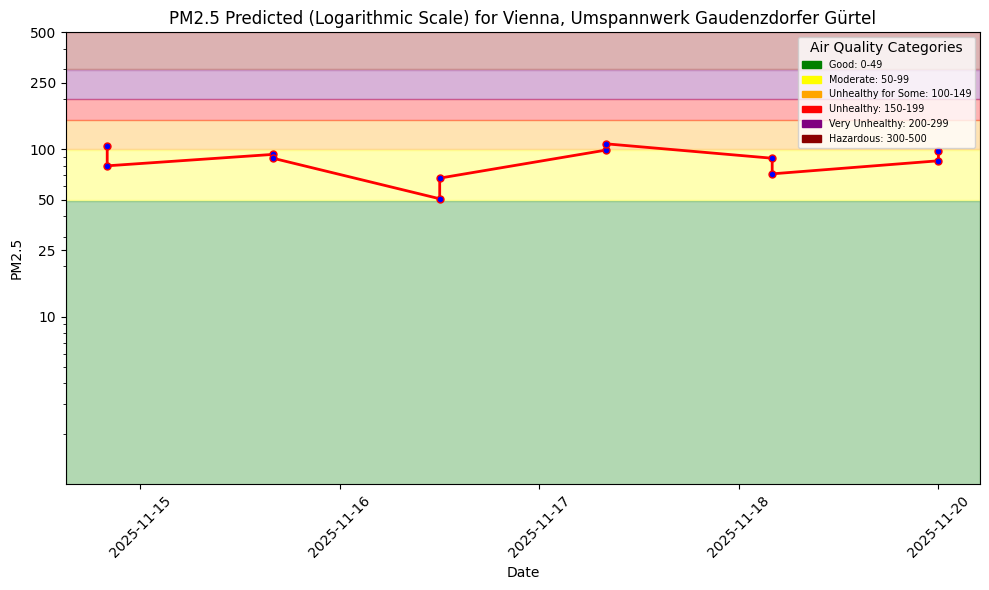

Generating forecast plot for Kendlerstraße 40 (Umspannwerk) (UID: 2850)


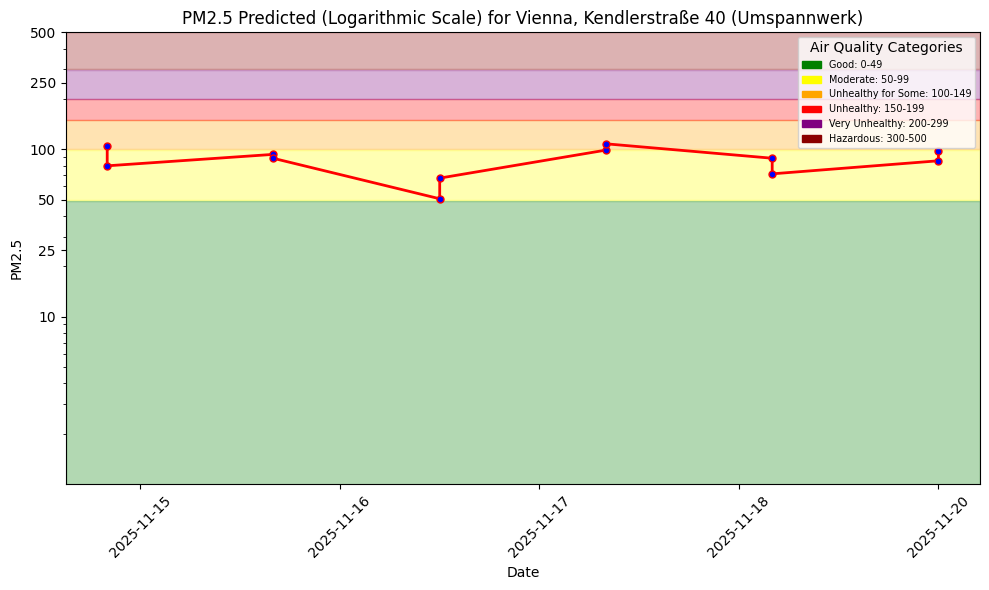

Generating forecast plot for Belgradplatz (Südostecke), Gstr.Nr. 816 (UID: 2870)


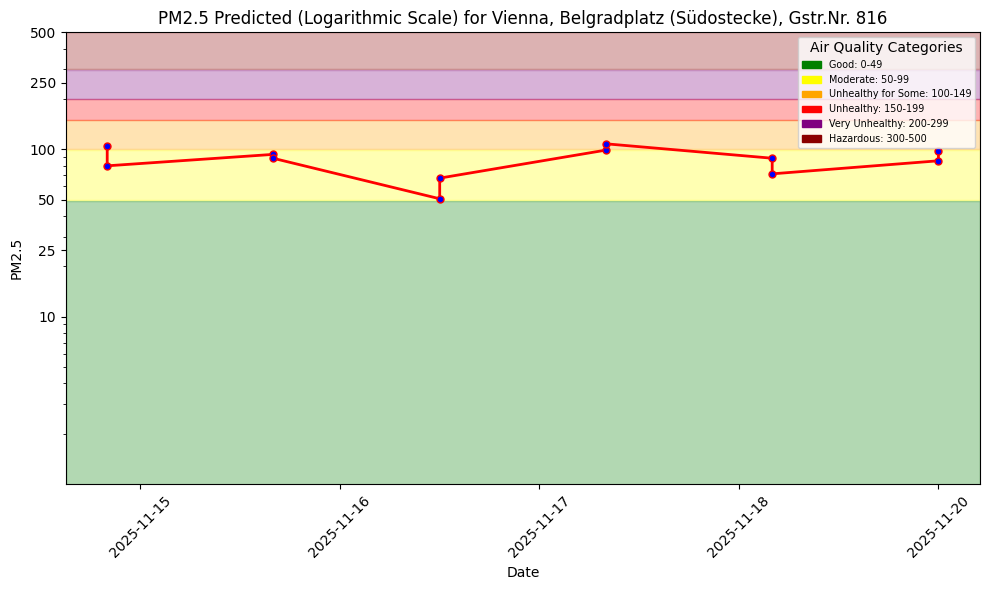

Generating forecast plot for Ecke Taborstraße - Glockengasse (UID: 2860)


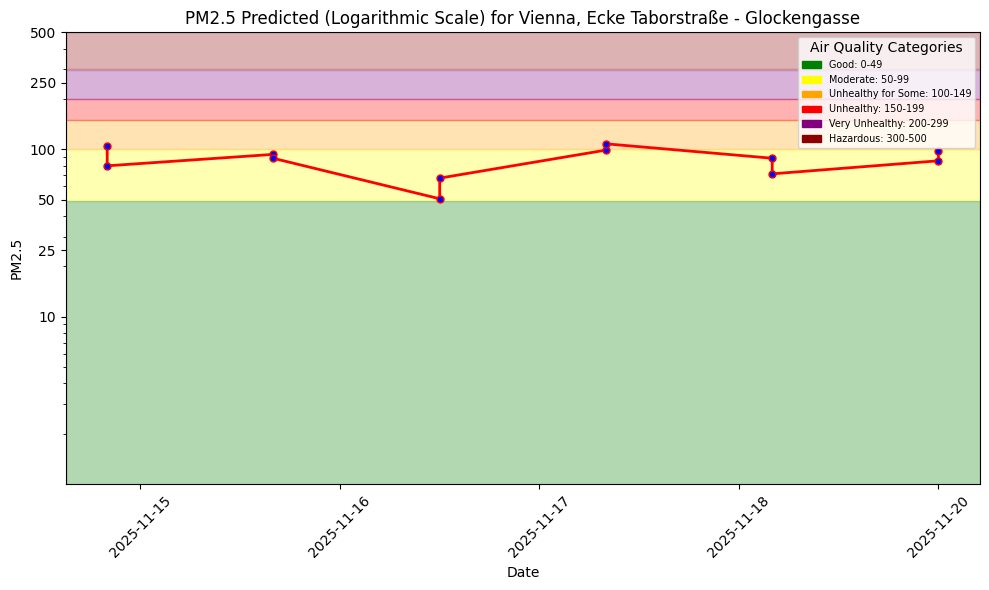

In [33]:

# pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
# plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

# plt.show()

base_img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(base_img_dir, exist_ok=True)

# Load station metadata (if not already done)
stations_path = f"{root_dir}/stations.json"
with open(stations_path, "r") as f:
    stations_meta = json.load(f)
stations_map = {s["uid"]: s for s in stations_meta}

# Ensure base /img folder exists
base_img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(base_img_dir, exist_ok=True)

print(f"📁 Base output directory: {base_img_dir}")

# Loop over each station UID
for uid, meta in stations_map.items():
    street = meta.get("street", f"station_{uid}")
    city = meta.get("city", "Vienna")

    # Filter prediction data for this station
    df_station = predictions_df[predictions_df["station_uid"] == uid].copy()
    if df_station.empty:
        print(f"No predictions found for {uid}, skipping.")
        continue

    # Create subfolder for this station inside /img
    station_dir = os.path.join(base_img_dir, str(uid))
    os.makedirs(station_dir, exist_ok=True)

    # Set path for saving the plot
    pred_file_path = os.path.join(station_dir, "pm25_forecast.png")

    print(f"Generating forecast plot for {street} (UID: {uid})")

    # Generate and save plot
    plt = util.plot_air_quality_forecast(city, street, df_station, pred_file_path)
    plt.show()
    plt.close()




In [34]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name="stations_air_quality_predictions",
    version=1,
    description="Predicted PM2.5 per station per date",
    primary_key=["station_uid", "date"],
)

# Insert predictions for monitoring
monitor_fg.insert(predictions_df)
print("Predictions successfully saved to Feature Group 'stations_air_quality_predictions'")


Uploading Dataframe: 100.00% |██████████| Rows 108/108 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: stations_air_quality_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1289364/jobs/named/stations_air_quality_predictions_1_offline_fg_materialization/executions
Predictions successfully saved to Feature Group 'stations_air_quality_predictions'


In [35]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df




Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,station_uid,street,country,days_before_forecast_day


In [38]:
# --- Block 1: Read air-quality Feature Group (all stations) ---
air_quality_fg = fs.get_feature_group(name='stations_air_quality_daily', version=1)
air_quality_df = air_quality_fg.read()

print(f" Loaded {len(air_quality_df)} rows from air-quality Feature Group.")
display(air_quality_df.head())


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.13s) from Hopsworks, using Hopsworks Feature Query Service.   Reading data from Hopsworks, using Hopsworks Feature Query Service...   
 Loaded 27676 rows from air-quality Feature Group.


,station_uid,date,pm25,country,city,street,url
0,2870,2022-03-12 00:00:00+00:00,41.0,austria,vienna,"Belgradplatz (Südostecke), Gstr.Nr. 816",https://aqicn.org/station/@2870/
1,2860,2019-05-22 00:00:00+00:00,27.0,austria,vienna,Ecke Taborstraße - Glockengasse,https://aqicn.org/station/@2860/
2,2855,2016-09-05 00:00:00+00:00,13.0,austria,vienna,"Hausgrundweg 23, Gstr. 254",https://aqicn.org/station/@2855/
3,2850,2025-03-20 00:00:00+00:00,56.0,austria,vienna,Kendlerstraße 40 (Umspannwerk),https://aqicn.org/station/@2850/
4,2850,2022-05-07 00:00:00+00:00,51.0,austria,vienna,Kendlerstraße 40 (Umspannwerk),https://aqicn.org/station/@2850/


In [39]:
# --- Block 2: Merge predictions with actual outcomes per station ---
hindcast_results = []  # collect hindcasts per station

# Load station metadata for station names
stations_path = f"{root_dir}/stations.json"
with open(stations_path, "r") as f:
    stations_meta = json.load(f)
stations_map = {s["uid"]: s for s in stations_meta}

for uid, meta in stations_map.items():
    city = meta.get("city", "Vienna")
    street = meta.get("street", f"station_{uid}")

    # Filter for this station
    preds_df = monitoring_df[monitoring_df["station_uid"] == uid][["date", "predicted_pm25"]].copy()
    actual_df = air_quality_df[air_quality_df["station_uid"] == uid][["date", "pm25"]].copy()

    # Merge predictions with actual measurements
    hindcast_df = pd.merge(preds_df, actual_df, on="date", how="inner")
    hindcast_df = hindcast_df.sort_values(by=["date"])

    if len(hindcast_df) == 0:
        print(f"⚠️ No outcomes found for station {uid} ({street}), skipping hindcast for now.")
        continue

    hindcast_results.append((uid, city, street, hindcast_df))

print(f"✅ Created hindcast DataFrames for {len(hindcast_results)} stations.")


⚠️ No outcomes found for station 4738 (Floridsdorf, Gerichtsgasse 1a (Prager Str. 65m)), skipping hindcast for now.
⚠️ No outcomes found for station 4739 (Schafbergbad, Josef Redl Gasse 2, Gstr.Nr. 698), skipping hindcast for now.
⚠️ No outcomes found for station 4736 (Wehlistraße 366, Gstr.Nr.2157), skipping hindcast for now.
⚠️ No outcomes found for station 14537 (Ostringweg (zwischen Gebäuden BT25)), skipping hindcast for now.
⚠️ No outcomes found for station 2855 (Hausgrundweg 23, Gstr. 254), skipping hindcast for now.
⚠️ No outcomes found for station 2857 (Umspannwerk Gaudenzdorfer Gürtel), skipping hindcast for now.
⚠️ No outcomes found for station 2850 (Kendlerstraße 40 (Umspannwerk)), skipping hindcast for now.
⚠️ No outcomes found for station 2870 (Belgradplatz (Südostecke), Gstr.Nr. 816), skipping hindcast for now.
⚠️ No outcomes found for station 2860 (Ecke Taborstraße - Glockengasse), skipping hindcast for now.
✅ Created hindcast DataFrames for 0 stations.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [40]:
# --- Block 3: Generate and save hindcast plots per station ---

base_img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(base_img_dir, exist_ok=True)

for uid, city, street, hindcast_df in hindcast_results:
    # Create subfolder for station
    station_dir = os.path.join(base_img_dir, str(uid))
    os.makedirs(station_dir, exist_ok=True)

    # Save plot under /img/<uid>/pm25_hindcast_1day.png
    hindcast_file_path = os.path.join(station_dir, "pm25_hindcast_1day.png")

    print(f"📊 Creating hindcast chart for {street} (UID {uid})...")
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()
    plt.close()


### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [41]:
# --- Block 4: Upload hindcast plots to Hopsworks Datasets ---
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

# Ensure dataset directory exists in Hopsworks
if not dataset_api.exists("Resources/airquality"):
    dataset_api.mkdir("Resources/airquality")

for uid, city, street, _ in hindcast_results:
    station_dir = os.path.join(base_img_dir, str(uid))
    hindcast_file_path = os.path.join(station_dir, "pm25_hindcast_1day.png")

    remote_path = f"Resources/airquality/{city}_{uid}_{str_today}"
    dataset_api.upload(hindcast_file_path, remote_path, overwrite=True)
    print(f"☁️ Uploaded hindcast for {street} (UID {uid}) to {remote_path}")

proj_url = project.get_url()
print(f"🌐 See all hindcast images in Hopsworks here:\n{proj_url}/settings/fb/path/Resources/airquality")


🌐 See all hindcast images in Hopsworks here:
https://c.app.hopsworks.ai:443/p/1289364/settings/fb/path/Resources/airquality


---